In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from patchify import patchify, unpatchify
import seaborn as sns
import random
import numpy as np
import math
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Flatten, Dense, Input, MaxPooling2D, Add, Reshape, concatenate, AveragePooling2D, Multiply, GlobalAveragePooling2D, UpSampling2D, MaxPool2D,Softmax
from tensorflow.keras.activations import softmax
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.optimizers import Adam
import pickle

from prediction import patches, prediction, psnr_and_ssim
from data_loader import Dataloader

In [5]:
X_train_patches, y_train_patches = pickle.load(open('train_data.pkl', 'rb'))
X_test_patches,y_test_patches = pickle.load(open('test_data.pkl', 'rb'))

In [6]:
X_train, y_train = pickle.load(open('train_path.pkl', 'rb'))
X_test, y_test = pickle.load(open('train_path.pkl', 'rb'))

In [7]:
# Normalization
X_train_patches = X_train_patches.astype('float32') / 255.0
y_train_patches = y_train_patches.astype('float32') / 255.0
X_test_patches = X_test_patches.astype('float32') / 255.0
y_test_patches = y_test_patches.astype('float32') / 255.0

In [9]:
batch_size = 32
train_dataloader = Dataloader(X_train_patches,y_train_patches, batch_size, shuffle=True)
test_dataloader = Dataloader(X_test_patches,y_test_patches,batch_size, shuffle=True)

# Second Network: CBDNET 

In [6]:
tf.keras.backend.clear_session()

input = Input(shape=(256, 256, 3))

# Noise estimation subnetwork
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
x = Conv2D(3, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)

# Non Blind denoising subnetwork
x = concatenate([x, input])
conv1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
conv2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv1)

pool1 = AveragePooling2D(pool_size=(2, 2), padding='same')(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool1)
conv4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv3)
conv5 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv4)

pool2 = AveragePooling2D(pool_size=(2, 2), padding='same')(conv5)
conv6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(pool2)
conv7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv6)
conv8 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv7)
conv9 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv8)
conv10 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv9)
conv11 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv10)

upsample1 = Conv2DTranspose(128, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv11)
add1 = Add()([upsample1,conv5])
conv12 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(add1)
conv13 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv12)
conv14 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv13)

upsample2 = Conv2DTranspose(64, (3, 3), strides=2, activation="relu", kernel_initializer='he_normal',padding="same")(conv14)
add1 = Add()([upsample2, conv2])
conv15 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(add1)
conv16 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(conv15)

out = Conv2D(3, (1, 1), kernel_initializer='he_normal', padding='same')(conv16)
out = Add()([out, input])

CBDNet = Model(input, out)
CBDNet.compile(optimizer=tf.keras.optimizers.Adam(1e-03), loss=tf.keras.losses.MeanSquaredError())
CBDNet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [15]:
log_dir="logs/cbdnet"

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1, write_graph=True,write_grads=True)
reducelr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1,patience=4,min_delta=0.00001)
callback = [tensorboard,reducelr]
CBDNet.fit(train_dataloader,shuffle=True,epochs=30,validation_data= test_dataloader,callbacks=callback)

Epoch 1/30
4096/4096 [==============================] - 128s 31ms/step - loss: 67957304590336.0000 - val_loss: 0.0027 - lr: 0.0010
Epoch 2/30
4096/4096 [==============================] - 108s 26ms/step - loss: 2.7074e-05 - val_loss: 0.0027 - lr: 0.0010
Epoch 3/30
4096/4096 [==============================] - 109s 27ms/step - loss: 2.7074e-05 - val_loss: 0.0027 - lr: 0.0010
Epoch 4/30
4096/4096 [==============================] - 108s 26ms/step - loss: 2.7074e-05 - val_loss: 0.0027 - lr: 0.0010
Epoch 5/30
4089/4096 [============================>.] - ETA: 0s - loss: 2.7073e-05
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
4096/4096 [==============================] - 108s 26ms/step - loss: 2.7073e-05 - val_loss: 0.0027 - lr: 0.0010
Epoch 6/30
4096/4096 [==============================] - 108s 26ms/step - loss: 2.7069e-05 - val_loss: 0.0027 - lr: 1.0000e-04
Epoch 7/30
4096/4096 [==============================] - 108s 26ms/step - loss: 2.7055e-05 - val_loss: 0.00

In [4]:
%tensorboard --logdir "/logs/cbdnet"

UsageError: Line magic function `%tensorboard` not found.


In [17]:
CBDNet.save('models/CBDNet', save_format='tf')

INFO:tensorflow:Assets written to: models/CBDNet\assets


INFO:tensorflow:Assets written to: models/CBDNet\assets


In [7]:
CBDNet = tf.keras.models.load_model('models/CBDNet')

In [17]:
sample = pd.DataFrame({'Ground Truth Images' : ['datasets/GT2.png'], 'Noisy Images' : ['datasets/N2.png']})

1/1 [==============================] - 0s 19ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


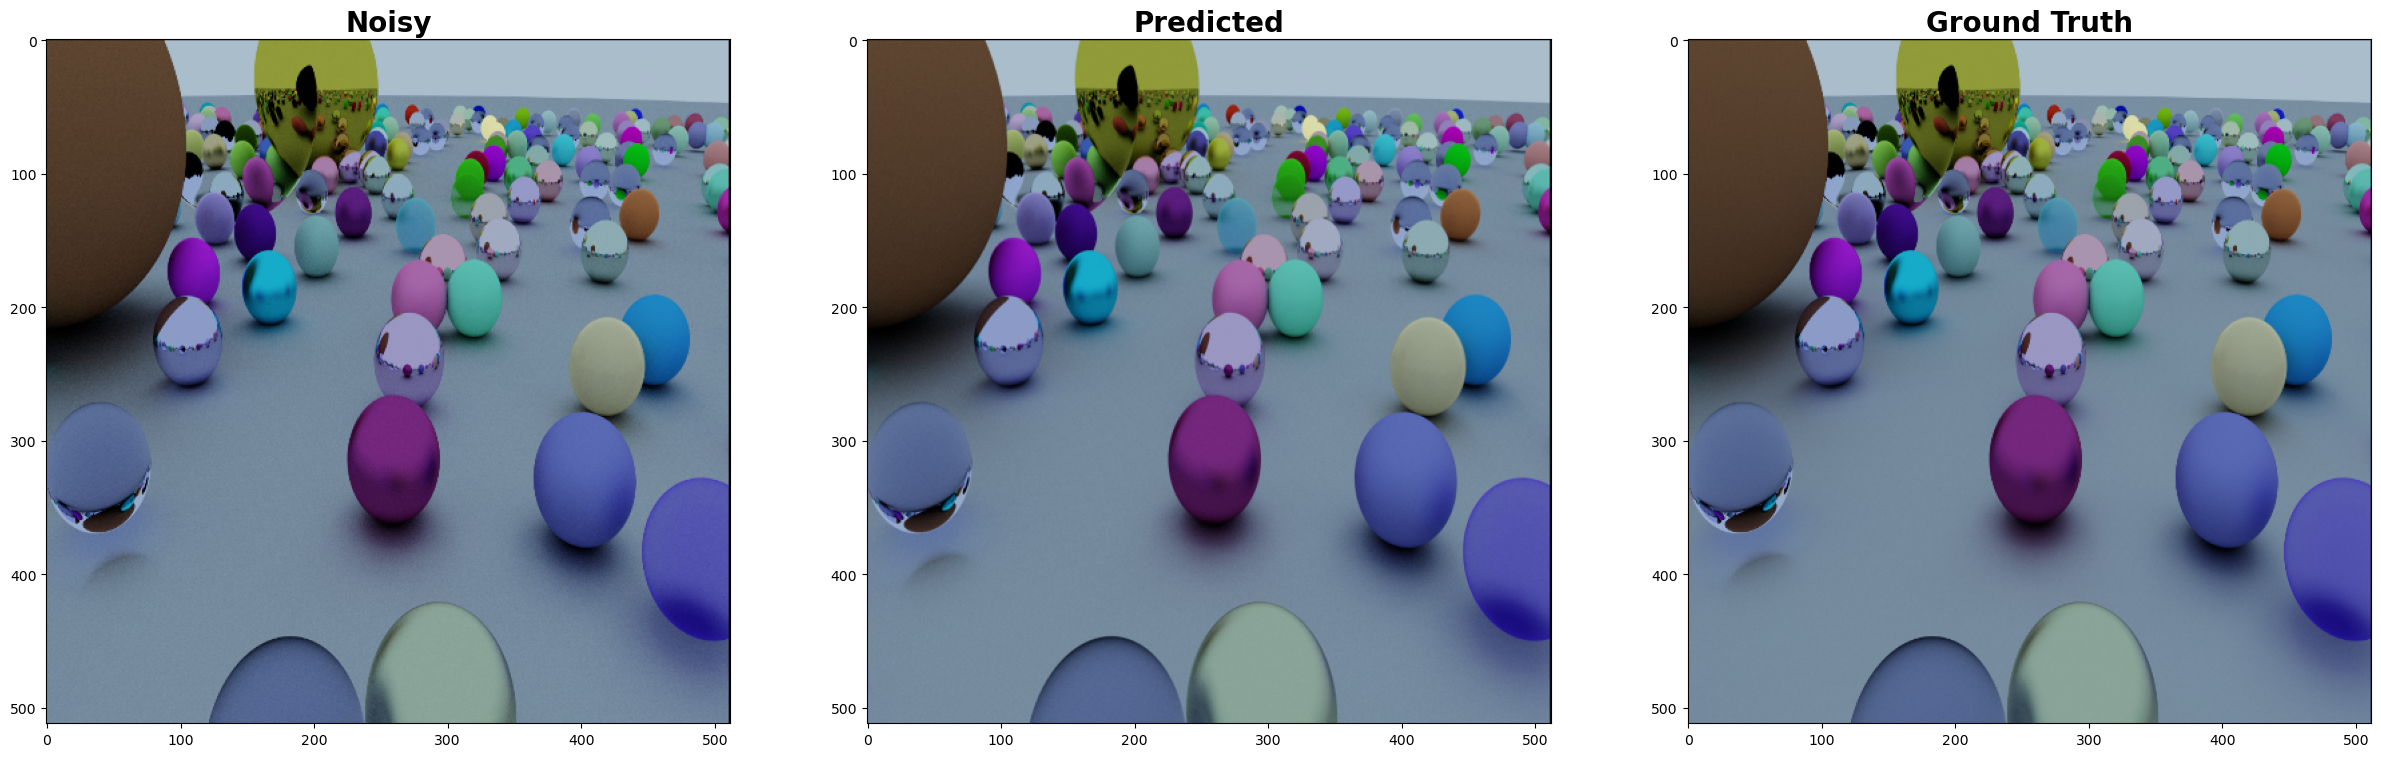

In [18]:
path = sample['Ground Truth Images'].iloc[0]
test_img_gt = cv2.imread(path)
test_img_gt = cv2.cvtColor(test_img_gt, cv2.COLOR_BGR2RGB)
test_img_gt = cv2.resize(test_img_gt, (512, 512))
test_img_gt = test_img_gt.astype("float32") / 255.0

path = sample['Noisy Images'].iloc[0]
test_img_nsy = cv2.imread(path)

pred = prediction(test_img_nsy, CBDNet)
pred = cv2.resize(pred, (512, 512))

test_img_nsy= cv2.cvtColor(test_img_nsy, cv2.COLOR_BGR2RGB)
test_img_nsy = cv2.resize(test_img_nsy, (512, 512))
test_img_nsy = test_img_nsy.astype("float32") / 255.0

fig, ax = plt.subplots(1, 3, figsize=(30,30))
ax[0].imshow(test_img_nsy)
ax[0].title.set_text('Noisy')
ax[0].title.set_size(20)
ax[0].title.set_fontweight('bold')
ax[1].imshow(pred)
ax[1].title.set_text('Predicted')
ax[1].title.set_fontweight('bold')
ax[1].title.set_size(20)
ax[2].imshow(test_img_gt)
ax[2].title.set_text('Ground Truth')
ax[2].title.set_fontweight('bold')
ax[2].title.set_size(20)
plt.show()

In [22]:
psnr_noisy = psnr(test_img_gt, test_img_nsy)
psnr_denoisy = psnr(test_img_gt, pred)
ssim_noisy = ssim(test_img_gt, test_img_nsy, multichannel=True, data_range=test_img_nsy.max() - test_img_nsy.min())
ssim_de_nsy = ssim(test_img_gt,pred,multichannel=True,data_range=pred.max() - pred.min())

print("PSNR of Noisy Image: ", psnr_noisy)
print("PSNR of Denoised Image: ", psnr_denoisy)
print("SSIM of Noisy Image: ", ssim_noisy)
print("SSIM of Denoised Image: ", ssim_de_nsy)

PSNR of Noisy Image:  33.1645541676306
PSNR of Denoised Image:  35.946734070294326
SSIM of Noisy Image:  0.83588046
SSIM of Denoised Image:  0.933706


C:\Users\Federico\AppData\Local\Temp\ipykernel_47520\3799999654.py:3: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_noisy = ssim(test_img_gt, test_img_nsy, multichannel=True, data_range=test_img_nsy.max() - test_img_nsy.min())
C:\Users\Federico\AppData\Local\Temp\ipykernel_47520\3799999654.py:4: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_de_nsy = ssim(test_img_gt,pred,multichannel=True,data_range=pred.max() - pred.min())


In [19]:
psnr_nsy, psnr_de_nsy, ssim_nsy, ssim_de_nsy = psnr_and_ssim(X_test, y_test, CBDNet)

print("PSNR before denoising: ", psnr_nsy)
print("PSNR after denoising: ", psnr_de_nsy)
print("SSIM before denoising: ", ssim_nsy)
print("SSIM after denoising: ", ssim_de_nsy)

datasets/SIDD_Medium_Srgb/Data/0086_004_GP_00100_00100_5500_L/0086_NOISY_SRGB_010.PNG
1/1 [==============================] - 0s 20ms/step


C:\Users\Federico\AppData\Local\Temp\ipykernel_34088\304908549.py:113: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_nsy += ssim(gt,nsy,multichannel=True,data_range=nsy.max() - nsy.min())
C:\Users\Federico\AppData\Local\Temp\ipykernel_34088\304908549.py:114: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_de_nsy += ssim(gt,pred,multichannel=True,data_range=pred.max() - pred.min())


datasets/SIDD_Medium_Srgb/Data/0199_010_GP_00800_01600_5500_N/0199_NOISY_SRGB_011.PNG
1/1 [==============================] - 0s 16ms/step
datasets/SIDD_Medium_Srgb/Data/0150_007_S6_00100_00100_5500_L/0150_NOISY_SRGB_010.PNG
1/1 [==============================] - 0s 17ms/step
datasets/SIDD_Medium_Srgb/Data/0197_009_IP_00100_00200_5500_L/0197_NOISY_SRGB_010.PNG
1/1 [==============================] - 0s 17ms/step
datasets/SIDD_Medium_Srgb/Data/0149_007_G4_00800_00800_4400_L/0149_NOISY_SRGB_010.PNG
1/1 [==============================] - 0s 17ms/step
datasets/SIDD_Medium_Srgb/Data/0080_004_S6_00200_00050_3200_N/0080_NOISY_SRGB_010.PNG
1/1 [==============================] - 0s 17ms/step
datasets/SIDD_Medium_Srgb/Data/0064_003_GP_01600_01600_4400_N/0064_NOISY_SRGB_011.PNG
1/1 [==============================] - 0s 17ms/step
datasets/SIDD_Medium_Srgb/Data/0069_003_IP_01000_02000_3200_N/0069_NOISY_SRGB_011.PNG
1/1 [==============================] - 0s 18ms/step
datasets/SIDD_Medium_Srgb/Data/016

In [11]:
from tensorflow.keras.export import ExportArchive

# CBDNet.export('models/exported/CBDNet')

export_archive = ExportArchive()
export_archive.track(CBDNet)
export_archive.add_endpoint(
    name='serve',
    fn=CBDNet.call,
    input_signature=[tf.TensorSpec(shape=(None, 3), dtype=tf.float32)],
)

export_archive.write_out('models/exported/CBDNet')

ModuleNotFoundError: No module named 'tensorflow.keras.export'

In [10]:
converter = tf.lite.TFLiteConverter.from_keras_model(CBDNet)
light_model = converter.convert()

with open('models/exported/CBDNet.tflite', 'wb') as f:
    f.write(light_model)

INFO:tensorflow:Assets written to: C:\Users\Federico\AppData\Local\Temp\tmp7ny1kgwp\assets


INFO:tensorflow:Assets written to: C:\Users\Federico\AppData\Local\Temp\tmp7ny1kgwp\assets
